In [1]:
import copy
import numpy as np
from typing import Callable
from tqdm import tqdm
import random as rand
import matplotlib.pyplot as plt

In [16]:
def f(x):
    return np.count_nonzero(x == 1)

class Specimen:
    def __init__(self, cost_function, cost_function_args=None, genotype: str = None, n_features: int = 30,
                 feature_size: int = 3, n_breed_points: int = 2, n_mutation_points: int = 2, mut_chance: float = 0.1,
                 network=None):

        self.network = copy.deepcopy(network)
        self.genotype = genotype
        self.n_features = n_features
        self.cost_function = cost_function
        self.cost_function_args = cost_function_args if cost_function_args is not None else ()
        self.feature_size = feature_size
        self.n_breed_points = n_breed_points
        self.n_mutation_points = n_mutation_points
        self.mut_chance = mut_chance
        self.score = None
        self.phenotype = None

    def calculate_score(self):
        if self.score is None:
            self.score = self.cost_function(self.phenotype)
        return self.score

    def calculate_phenotype(self):
        idx = 0

        for layer in self.network.layers:
            input_size = int(np.ceil(np.log2(layer.input_size)))
            for gate in layer.gates:
                first_idx = int(self.genotype[idx:idx + input_size], 2)
                second_idx = int(self.genotype[idx + input_size:idx + input_size * 2], 2)

                while second_idx >= layer.input_size:
                    second_idx = np.random.randint(0, layer.input_size - 1)

                while first_idx >= layer.input_size:
                    first_idx = np.random.randint(0, layer.input_size - 1)

                while first_idx == second_idx:
                    first_idx = np.random.randint(0, layer.input_size - 1)

                gate.set_indices((first_idx, second_idx))
                idx += input_size * 2

        for layer in self.network.layers:
            for gate in layer.gates:
                genetic_unit = self.genotype[idx:idx+3]
                gate.set_operator(DICT_GATES[genetic_unit])
                idx += 3

        self.phenotype = self.network.predict(data)

    def breed(self, other):
        splitted_self = [bit for bit in self.genotype]
        splitted_other = [bit for bit in other.genotype]
        split_places = [rand.randint(1, len(splitted_self) - 2) for _ in range(self.n_breed_points)]
        split_places.sort()
        genotype_A = []
        genotype_B = []

        for idx in range(self.n_breed_points):
            genotype_A = splitted_self[:split_places[idx]] + splitted_other[split_places[idx]:]
            genotype_B = splitted_other[:split_places[idx]] + splitted_self[split_places[idx]:]

        merged_genotype_A = ''.join(genotype_A)
        merged_genotype_B = ''.join(genotype_B)

        return Specimen(cost_function=self.cost_function, cost_function_args=self.cost_function_args,
                        genotype=merged_genotype_A,
                        n_features=self.n_features, feature_size=self.feature_size, n_breed_points=self.n_breed_points,
                        n_mutation_points=self.n_mutation_points,
                        mut_chance=self.mut_chance,
                        network=self.network), \
            Specimen(cost_function=self.cost_function, cost_function_args=self.cost_function_args,
                     genotype=merged_genotype_B,
                     n_features=self.n_features, feature_size=self.feature_size, n_breed_points=self.n_breed_points,
                     n_mutation_points=self.n_mutation_points,
                     mut_chance=self.mut_chance,
                     network=self.network)

    def mutate(self):
        mutation_list = [idx for idx in range(self.n_mutation_points + 1)]
        weights = []
        splitted = [bit for bit in self.genotype]
        mutated = []

        for i in mutation_list:
            if i == 0:
                weights.append(1 - self.mut_chance)
            else:
                weights.append(self.mut_chance / (len(mutation_list) - 1))

        mutations_left = rand.choices(mutation_list, weights=weights)[0]

        while mutations_left != 0:
            point_mutation = rand.randint(0, len(splitted) - 1)

            if point_mutation not in mutated:
                if splitted[point_mutation] == '0':
                    splitted[point_mutation] = '1'
                    mutations_left = mutations_left - 1
                else:
                    splitted[point_mutation] = '0'
                    mutations_left = mutations_left - 1
                mutated.append(point_mutation)
            else:
                continue

        self.genotype = ''.join(splitted)  # calculate fenotype after

    def __str__(self):
        return str(self.phenotype)

    def __repr__(self):
        return str(self.phenotype)


class GeneticAlgorithm:
    def __init__(self, cost_function, cost_function_args=None, n_specimens: int = 100, breed_chance: float = 0.8,
                 n_breed_points: int = 2, mut_chance: float = 0.1, n_mutation_points: int = 10, n_features: int = 3,
                 feature_size: int = 30, n_jobs: int = 1, network=None):

        self.network = network
        self.starting_genotype = str()

        for layer in self.network.layers:
            input_size = int(np.ceil(np.log2(layer.input_size)))
            for gate in layer.gates:

                first_idx = bin(gate.indices[0])[2:]
                while len(first_idx) != input_size:
                    first_idx = '0' + first_idx

                second_idx = bin(gate.indices[1])[2:]
                while len(second_idx) != input_size:
                    second_idx = '0' + second_idx

                self.starting_genotype += first_idx + second_idx


        for layer in self.network.layers:
            for gate in layer.gates:
                self.starting_genotype += (np.random.choice([k for k, v in DICT_GATES.items() if v == gate.operator]))

        self.cost_function = cost_function
        self.cost_function_args = cost_function_args
        self.n_specimens = n_specimens
        self.breed_chance = breed_chance
        self.n_breed_points = n_breed_points
        self.mut_chance = mut_chance
        self.n_mutation_points = n_mutation_points
        self.n_features = n_features
        self.feature_size = feature_size
        self.n_jobs = n_jobs
        self.population = [Specimen(self.cost_function, n_features=self.n_features,
                                    feature_size=self.feature_size,
                                    n_breed_points=self.n_breed_points,
                                    n_mutation_points=self.n_mutation_points,
                                    mut_chance=self.mut_chance,
                                    cost_function_args=self.cost_function_args,
                                    network=self.network,
                                    genotype=self.starting_genotype) for _ in range(self.n_specimens)]

    def natural_selection(self, roulette=True):
        for specimen in self.population:
            specimen.calculate_phenotype()
            specimen.calculate_score()

        if roulette:
            n_survivors = (len(self.population) * self.breed_chance)
            score_sum = 0
            weights = []
            new_population = []

            for specimen in self.population:
                score_sum += specimen.score

            for specimen in self.population:
                try:
                    weights.append(specimen.score / score_sum)
                except:
                    weights = None

            while len(new_population) != n_survivors:
                winner = np.random.choice(self.population, replace=False, p=weights)
                new_population.append(winner)

            while len(new_population) != len(self.population):
                new_population.append(rand.choices(new_population))

            np.random.shuffle(new_population)
            self.population = new_population

        else:
            new_population = []
            n_survivors = (len(self.population) * self.breed_chance)
            sorted_population = sorted(self.population, key=lambda x: x.score, reverse=True)

            fittest = sorted_population[:int(n_survivors)]

            while len(new_population) != len(self.population):
                new_population.append(np.random.choice(fittest, replace=True))

            np.random.shuffle(new_population)
            self.population = new_population

    def breed_population(self):
        new_population = []
        for idx in range(0, len(self.population), 2):
            specimen_A = self.population[idx]
            specimen_B = self.population[idx + 1]

            if rand.random() <= self.breed_chance:
                child_A, child_B = specimen_A.breed(specimen_B)
                new_population.append(child_A)
                new_population.append(child_B)
            else:
                new_population.append(specimen_A)
                new_population.append(specimen_B)
        self.population = new_population

    def run(self, n_iter: int = 100, verbose: bool = True):
        title = f""
        pbar = tqdm(range(n_iter), disable=not verbose, desc=title)
        scores_over_time = []
        for _ in pbar:

            self.breed_population()

            for specimen in self.population:
                specimen.mutate()

            self.natural_selection(roulette=False)

            for specimen in self.population:
                specimen.calculate_phenotype()
                specimen.calculate_score()

            scores = np.array([specimen.score for specimen in self.population])
            best_score = max(scores)
            scores_over_time.append(best_score)
            title = f"Current biggest score: {best_score:.4f}"
            pbar.set_description(title)

        return scores_over_time

    def get_best(self):
        scores = np.array([specimen.score for specimen in self.population])
        best_score = max(scores)
        best_genotype = self.population[np.argmax(scores)].genotype
        return best_genotype, best_score

In [17]:
def not_gate(x):
    return np.logical_not(*x.T).reshape(-1, 1)


def and_gate(x):
    return np.logical_and(*x.T).reshape(-1, 1)


def nand_gate(x):
    return not_gate(and_gate(x))


def or_gate(x):
    return np.logical_or(*x.T).reshape(-1, 1)


def nor_gate(x):
    return not_gate(or_gate(x))


def xor_gate(x):
    return np.logical_xor(*x.T).reshape(-1, 1)


def xnor_gate(x):
    return not_gate(xor_gate(x))


GATES = [not_gate, and_gate, or_gate, nand_gate, nor_gate, xor_gate, xnor_gate]
DICT_GATES = {'000': not_gate,
              '001': and_gate,
              '010': or_gate,
              '011': nand_gate,
              '100': nor_gate,
              '101': xor_gate,
              '110': xnor_gate,
              '111': not_gate
              }

class Gate:
    def __init__(self, indices: tuple, operator: Callable) -> None:
        self.indices = indices
        self.operator = operator

        self.input = None
        self.output = None

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        self.input = inputs[:, self.indices]
        self.output = self.operator(self.input)
        return self.output

    def set_indices(self, indices: tuple) -> None:
        self.indices = indices

    def set_operator(self, operator: Callable) -> None:
        self.operator = operator

In [18]:
class Layer:
    def __init__(self, input_size: int, output_size: int) -> None:
        self.input_size = input_size
        self.output_size = output_size

        self.gates = []
        for _ in range(self.output_size):
            indices = np.random.choice(self.input_size, size=2, replace=False)
            operator = np.random.choice(GATES)
            self.gates.append(Gate(indices, operator))

    def forward(self, x: np.ndarray) -> np.ndarray:
        n_samples, n_dim = x.shape

        assert n_dim == self.input_size, f'Size ain\'t fit'

        output = np.zeros((n_samples, self.output_size))
        for idx, gate in enumerate(self.gates):
            output[:, idx] = gate.forward(x).reshape(-1)

        return output

In [19]:
class Network:
    def __init__(self, input_size: int) -> None:
        self.input_size = input_size
        self.layers = []

    def add_layer(self, output_size: int) -> None:
        if not len(self.layers):
            self.layers.append(Layer(self.input_size, output_size))
        else:
            self.layers.append(Layer(self.layers[-1].output_size, output_size))

    def predict(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [31]:
def tune_network(network: Network, genotype: str) -> None:
        idx = 0

        for layer in network.layers:
            input_size = int(np.ceil(np.log2(layer.input_size)))
            for gate in layer.gates:
                first_idx = int(genotype[idx:idx + input_size], 2)
                second_idx = int(genotype[idx + input_size:idx + input_size * 2], 2)

                while second_idx >= layer.input_size:
                    second_idx = np.random.randint(0, layer.input_size - 1)

                while first_idx >= layer.input_size:
                    first_idx = np.random.randint(0, layer.input_size - 1)

                while first_idx == second_idx:
                    first_idx = np.random.randint(0, layer.input_size - 1)

                gate.set_indices((first_idx, second_idx))
                idx += input_size * 2

        for layer in network.layers:
            for gate in layer.gates:
                genetic_unit = genotype[idx:idx+3]
                gate.set_operator(DICT_GATES[genetic_unit])
                idx += 3

In [34]:
np.random.seed(100)
data = np.random.randint(2, size=(100, 16))

In [35]:
lgn = Network(input_size=data.shape[1])
lgn.add_layer(output_size=10)
lgn.add_layer(output_size=15)
lgn.add_layer(output_size=10)

genetic = GeneticAlgorithm(f, n_specimens=1000, network=lgn)
scores_over_time = genetic.run(250)
best_genotype, best_score = genetic.get_best()

Current biggest score: 1000.0000: 100%|██████████| 250/250 [11:01<00:00,  2.65s/it]


In [36]:
tune_network(lgn, best_genotype)
output = lgn.predict(data)
print(np.count_nonzero(output == 1))

1000


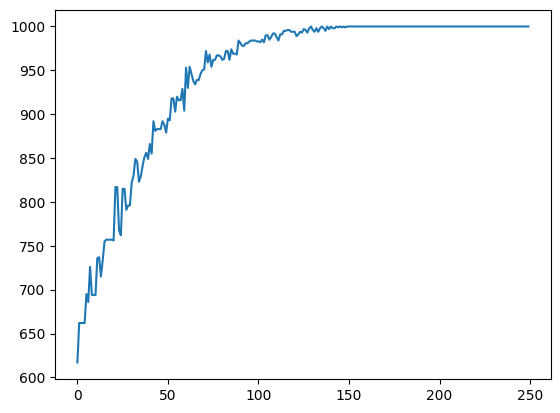

In [37]:
plt.plot(range(len(scores_over_time)), scores_over_time)
plt.show()

In [ ]:
lgn = Network(input_size=data.shape[1])
lgn.add_layer(output_size=8)
lgn.add_layer(output_size=16)
lgn.add_layer(output_size=16)

genetic = GeneticAlgorithm(f, n_specimens=1000, network=lgn)
scores_over_time = genetic.run(250)
best_genotype, best_score = genetic.get_best()
plt.plot(range(len(scores_over_time)), scores_over_time)
plt.show()

In [ ]:
tune_network(lgn, best_genotype)
output = lgn.predict(data)
print(np.count_nonzero(output == 1))